In [1]:
# Install necessary libraries
!pip install langchain-openai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
## Libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import yfinance as yf
from langchain_openai import ChatOpenAI
from scipy.optimize import minimize

In [4]:
# Function to initialize OpenAI LLM model
def initialize_llm(api_key):
    """
    Initialize the ChatOpenAI language model.

    Parameters:
    api_key (str): The API key for accessing the OpenAI service.

    Returns:
    ChatOpenAI: The initialized language model.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key)
    return llm

In [5]:
# Function to calculate start and end dates based on the number of years from today
def calculate_date_range(years):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=years * 365)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')


In [6]:
# Function to invoke LLM response based on given prompt
def get_llm_response(llm, prompt):
    """
    Get the response from the language model for a given prompt.

    Parameters:
    llm (ChatOpenAI): The initialized language model.
    prompt (str): The prompt to send to the language model.

    Returns:
    str: The content of the language model's response.
    """
    response = llm(prompt)
    return display(Markdown(response.content))

In [7]:
# Plots the RSI for a given stock and highlights overbought and oversold thresholds.
def plot_rsi(data, ticker):
    """
    Plot the Relative Strength Index (RSI) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the lookback window for RSI calculation
    window = 14

    # Calculate the RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Plot the RSI
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, rsi, label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--')        # Add a horizontal line at RSI = 70 (overbought threshold)
    plt.axhline(30, color='green', linestyle='--')      # Add a horizontal line at RSI = 30 (oversold threshold)

    # Add title, labels, and legend
    plt.title(f'RSI of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()


In [8]:
# Plot Bollinger Bands, including the closing price, middle band (SMA), and upper/lower bands (±2 standard deviations).
def plot_bollinger_bands(data, ticker):
    """
    Plot the Bollinger Bands for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the rolling window period for Bollinger Bands
    window = 20

    # Calculate the middle band (simple moving average) and outer bands (±2 standard deviations)
    data['Middle Band'] = data['Close'].rolling(window=window).mean()
    data['Upper Band'] = data['Middle Band'] + 2 * data['Close'].rolling(window=window).std()  # Upper band
    data['Lower Band'] = data['Middle Band'] - 2 * data['Close'].rolling(window=window).std()  # Lower band

    # Plot the closing price and Bollinger Bands
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['Close'], label='Closing Price')  # Plot closing price
    plt.plot(data.index, data['Middle Band'], label='Middle Band', color='blue')  # Plot middle band
    plt.plot(data.index, data['Upper Band'], label='Upper Band', color='red')  # Plot upper band
    plt.plot(data.index, data['Lower Band'], label='Lower Band', color='green')  # Plot lower band

    # Add title, labels, and legend
    plt.title(f'Bollinger Bands of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
# Plots the Price-to-Earnings (P/E) ratios over time for a list of stocks, using their historical closing prices and trailing EPS.
def plot_pe_ratios(data, ticker, eps):
    """
    Plot the Price-to-Earnings (P/E) ratio for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.
    eps (float): The earnings per share of the stock.

    Returns:
    None
    """
    # Check if EPS value is valid
    if eps is None or eps == 0:
        print(f"Warning: EPS for {ticker} is not available or zero. PE ratio can't be calculated.")
        return

    # Calculate the P/E ratio
    pe_ratio = data['Close'] / eps

    # Create and customize the plot
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, pe_ratio, label=f'{ticker} PE Ratio')
    plt.title('PE Ratios of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('PE Ratio')
    plt.legend()
    plt.show()


In [10]:
# Plots a bar chart comparing beta values of the given stock tickers.
def plot_beta_comparison(tickers, start_date, end_date):
    betas = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            # Retrieve historical data
            data = stock.history(start=start_date, end=end_date)
            # Get the beta value from stock's info
            beta = stock.info.get('beta')

            # Skip to the next ticker if beta is not available
            if beta is None:
                print(f"Warning: Beta for {ticker} is not available.")
                continue

            betas[ticker] = beta # Store the beta value

        # Handle errors related to missing data
        except KeyError as e:
            print(f"Error retrieving data for {ticker}: {e}")
        # Handle other unexpected errors
        except Exception as e:
            print(f"An error occurred with ticker {ticker}: {e}")

    # Plotting the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(betas.keys(), betas.values(), color='blue')
    plt.title('Beta Comparison of Selected Stocks')
    plt.xlabel('Ticker')
    plt.ylabel('Beta')
    plt.show()

In [11]:
# Plots the MACD and signal line for each ticker to show momentum trends.
def plot_macd(data, ticker):
    """
    Plot the Moving Average Convergence Divergence (MACD) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Calculate the 12-day and 26-day EMA
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()

    # Calculate the MACD
    macd = ema_12 - ema_26

    # Calculate the signal line
    signal = macd.ewm(span=9, adjust=False).mean()

    # Plot MACD and signal line
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, macd, label=f'{ticker} MACD')
    plt.plot(data.index, signal, label=f'{ticker} Signal Line')
    plt.title(f'MACD and Signal Line of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()


In [12]:
# Calculates and returns key performance indicators (RSI, Bollinger Bands, P/E Ratio, Beta, and MACD) for a list of stock tickers over a specified date range.
def calculate_kpis(tickers, start_date, end_date):
    """
    Calculate KPIs for a list of stocks over a given time period.

    Parameters:
    tickers (list): A list of stock ticker symbols.
    start_date (str): The start date for the analysis.
    end_date (str): The end date for the analysis.

    Returns:
    dict: A dictionary containing the KPIs for each stock.
    """
    kpi_data = {}
    for ticker in tickers:
        # Download historical stock data
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        kpi_data[ticker] = {}

        # Calculate RSI
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()      # Average gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()     # Average losses
        rs = gain / loss                                                  # Relative strength
        rsi = 100 - (100 / (1 + rs))                                      # RSI formula
        kpi_data[ticker]['RSI'] = rsi

        # Calculate Bollinger Bands
        middle_band = data['Close'].rolling(window=20).mean()                     # Middle band (SMA)
        upper_band = middle_band + 2 * data['Close'].rolling(window=20).std()     # Upper band
        lower_band = middle_band - 2 * data['Close'].rolling(window=20).std()     # Lower band
        kpi_data[ticker]['Bollinger Bands'] = {
            'Middle Band': middle_band,
            'Upper Band': upper_band,
            'Lower Band': lower_band
        }

        # Calculate P/E Ratio
        try:
            eps = stock.info.get('trailingEps') # Get trailing EPS
            if eps and eps != 0:
                pe_ratio = data['Close'] / eps
                kpi_data[ticker]['P/E Ratio'] = pe_ratio # Calculate P/E ratio
            else:
                kpi_data[ticker]['P/E Ratio'] = None
        except Exception as e:
            kpi_data[ticker]['P/E Ratio'] = None
            print(f"An error occurred with ticker {ticker} P/E Ratio: {e}")

        # Calculate Beta
        try:
            beta = stock.info.get('beta') # Get beta value
            kpi_data[ticker]['Beta'] = beta
        except Exception as e:
            kpi_data[ticker]['Beta'] = None
            print(f"An error occurred with ticker {ticker} Beta: {e}")

        # Calculate MACD
        ema_12 = data['Close'].ewm(span=12, adjust=False).mean()    # 12-day EMA
        ema_26 = data['Close'].ewm(span=26, adjust=False).mean()    # 26-day EMA
        macd = ema_12 - ema_26    # MACD line
        signal = macd.ewm(span=9, adjust=False).mean()   # Signal line
        kpi_data[ticker]['MACD'] = {
            'MACD': macd,
            'Signal Line': signal
        }

    return kpi_data


In [13]:
# Intialize OpenAI LLM
llm = initialize_llm(api_key=api_key)

In [14]:
# Define the number of years for the analysis
years = 2  # Example: 2 years

In [15]:
# List of assets to analyze
assets = [
    "Apple (AAPL)",
    "Amazon (AMZN)",
    "Bitcoin (BTC-USD)",
    "Alphabet (GOOGL)",
    "Meta (META)",
    "Microsoft (MSFT)",
    "Nvidia (NVDA)",
    "S&P 500 index (SPY)",
    "Tesla (TSLA)"
]

In [16]:
# Query to fetch and sort tickers alphabetically from a list of specified assets
query = f"""
fetch me the tickers from the following assets: {assets}
Your output must be sorted alhabetically by the ticker and it should be like this:
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
"""

In [25]:
# Feed prompt to LLM model, and invoke response
get_llm_response(llm = llm, prompt = query)

Here is the sorted list of tickers:

```python
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
```

In [26]:
# Convert asset names to their ticker symbols
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

In [27]:
# Calculate the start and end dates
start_date, end_date = calculate_date_range(years)

# Fetch historical stock data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the fetched data
data.head()

[*********************100%***********************]  9 of 9 completed


Price                       Adj Close                                        \
Ticker                           AAPL        AMZN       BTC-USD       GOOGL   
Date                                                                          
2022-10-14 00:00:00+00:00  136.863571  106.900002  19185.656250   96.321487   
2022-10-15 00:00:00+00:00         NaN         NaN  19067.634766         NaN   
2022-10-16 00:00:00+00:00         NaN         NaN  19268.093750         NaN   
2022-10-17 00:00:00+00:00  140.849411  113.790001  19550.757812   99.723076   
2022-10-18 00:00:00+00:00  142.174728  116.360001  19334.416016  100.521095   

Price                                                                     \
Ticker                           META        MSFT       NVDA         SPY   
Date                                                                       
2022-10-14 00:00:00+00:00  126.379486  224.686539  11.216743  347.389771   
2022-10-15 00:00:00+00:00         NaN         NaN        NaN         NaN   
2022-10-16 00:00:00+00:00         NaN         NaN        NaN         NaN   
2022-10-17 00:00:00+00:00  133.637634  233.504532  11.877138  356.316620   
2022-10-18 00:00:00+00:00  132.401352  234.458084  11.956068  360.503235   

Price                                       Close  ...        Open  \
Ticker                           TSLA        AAPL  ...        TSLA   
Date                                               ...               
2022-10-14 00:00:00+00:00  204.990005  138.380005  ...  224.009995   
2022-10-15 00:00:00+00:00         NaN         NaN  ...         NaN   
2022-10-16 00:00:00+00:00         NaN         NaN  ...         NaN   
2022-10-17 00:00:00+00:00  219.350006  142.410004  ...  210.039993   
2022-10-18 00:00:00+00:00  220.190002  143.750000  ...  229.500000   

Price                          Volume                                       \
Ticker                           AAPL        AMZN      BTC-USD       GOOGL   
Date                                                                         
2022-10-14 00:00:00+00:00  88598000.0  67737300.0  38452356727  25410700.0   
2022-10-15 00:00:00+00:00         NaN         NaN  16192235532         NaN   
2022-10-16 00:00:00+00:00         NaN         NaN  17988916650         NaN   
2022-10-17 00:00:00+00:00  85250900.0  62782000.0  27472552998  28419200.0   
2022-10-18 00:00:00+00:00  99136600.0  65607400.0  30580012344  24060700.0   

Price                                                                        \
Ticker                           META        MSFT         NVDA          SPY   
Date                                                                          
2022-10-14 00:00:00+00:00  23559400.0  30198600.0  713432000.0  123737000.0   
2022-10-15 00:00:00+00:00         NaN         NaN          NaN          NaN   
2022-10-16 00:00:00+00:00         NaN         NaN          NaN          NaN   
2022-10-17 00:00:00+00:00  29612200.0  28142300.0  580774000.0   93168200.0   
2022-10-18 00:00:00+00:00  25445000.0  26329600.0  659362000.0   97162900.0   

Price                                  
Ticker                           TSLA  
Date                                   
2022-10-14 00:00:00+00:00  94124500.0  
2022-10-15 00:00:00+00:00         NaN  
2022-10-16 00:00:00+00:00         NaN  
2022-10-17 00:00:00+00:00  79428800.0  
2022-10-18 00:00:00+00:00  75891900.0  

[5 rows x 54 columns]

# Outputs

### RSI

**What is RSI:** The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI values above 70 indicate that a stock may be overbought, while values below 30 suggest it may be oversold.

**How to Interpret:** High RSI values (>70) indicate overbought conditions, potentially signaling a sell opportunity. Low RSI values (<30) indicate oversold conditions, potentially signaling a buy opportunity.

[*********************100%***********************]  1 of 1 completed


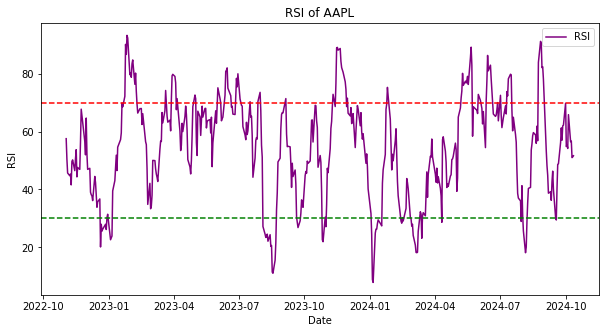

[*********************100%***********************]  1 of 1 completed


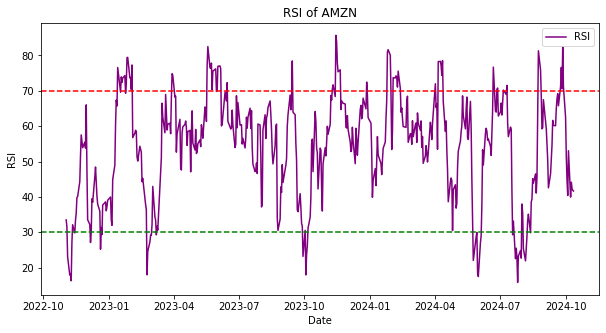

[*********************100%***********************]  1 of 1 completed


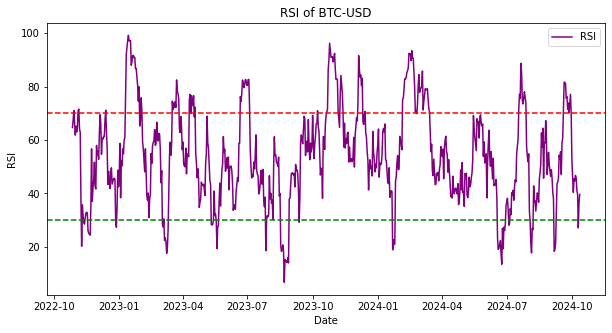

[*********************100%***********************]  1 of 1 completed


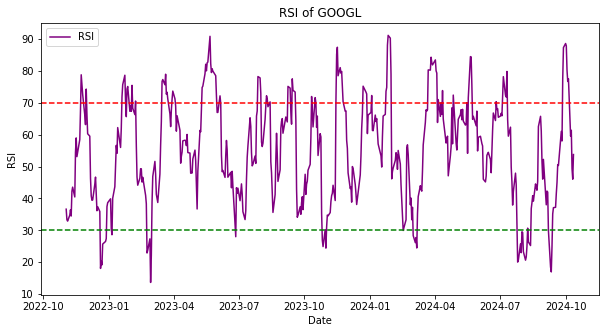

[*********************100%***********************]  1 of 1 completed


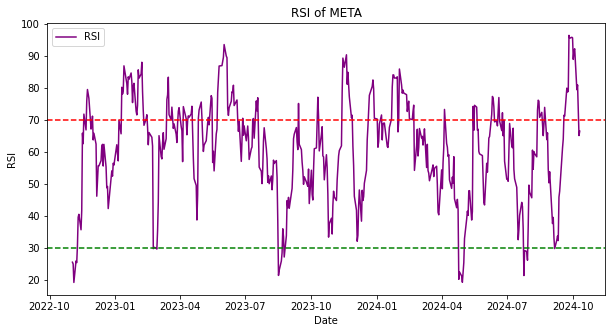

[*********************100%***********************]  1 of 1 completed


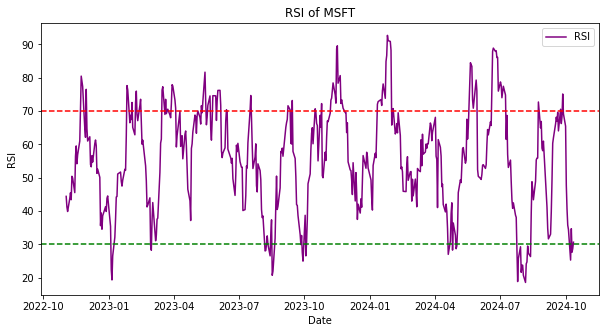

[*********************100%***********************]  1 of 1 completed


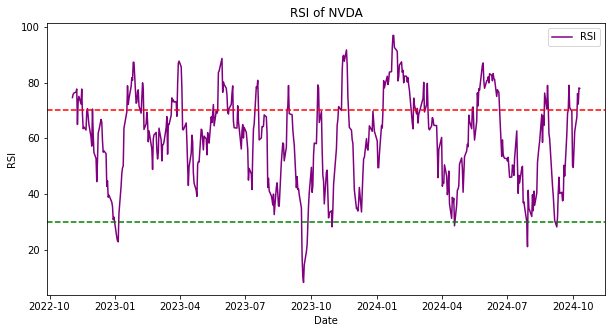

[*********************100%***********************]  1 of 1 completed


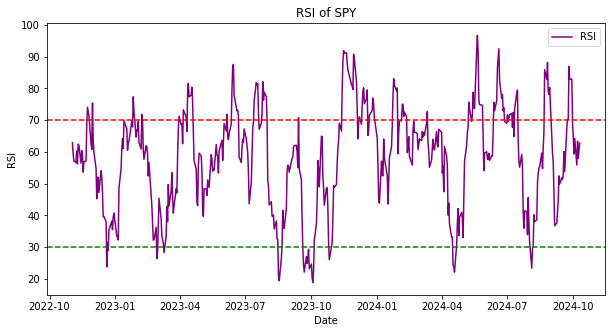

[*********************100%***********************]  1 of 1 completed


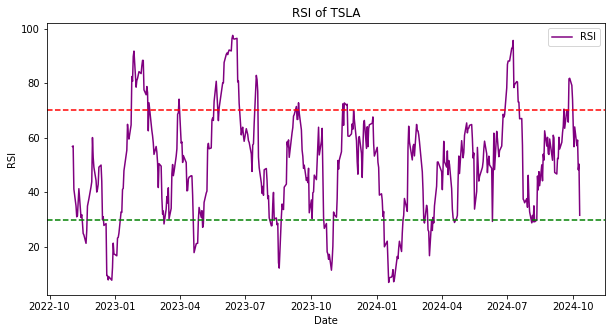

In [28]:
# Download historical data for each ticker and plot its RSI
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_rsi(data_ticker, ticker)

### Bollinger Bands

**What are Bollinger Bands:** Bollinger Bands consist of a middle band (simple moving average) and two outer bands (standard deviations). They help identify overbought and oversold conditions.

**How to Interpret:** When the price touches the upper band, it may indicate that the stock is overbought. Conversely, touching the lower band may indicate that the stock is oversold.

[*********************100%***********************]  1 of 1 completed


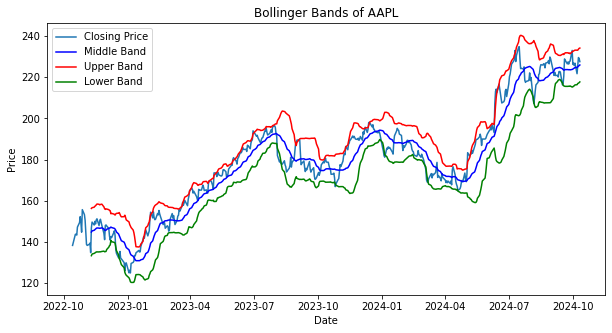

[*********************100%***********************]  1 of 1 completed


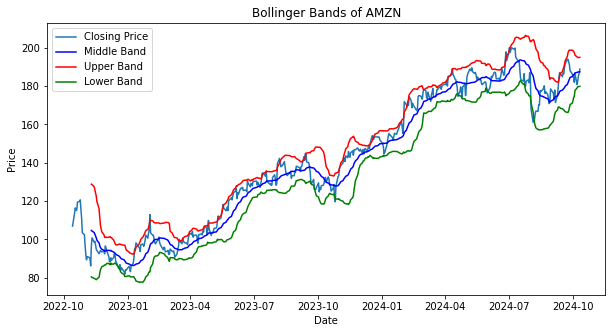

[*********************100%***********************]  1 of 1 completed


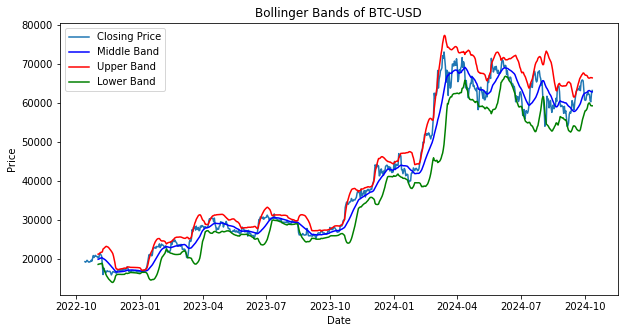

[*********************100%***********************]  1 of 1 completed


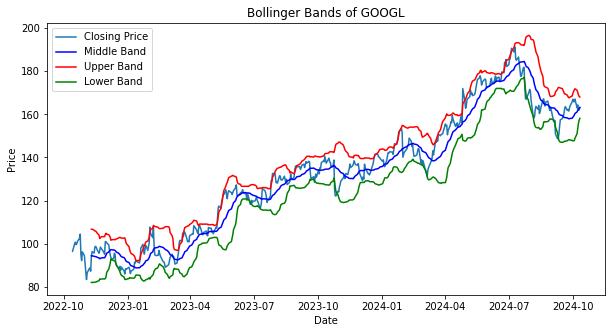

[*********************100%***********************]  1 of 1 completed


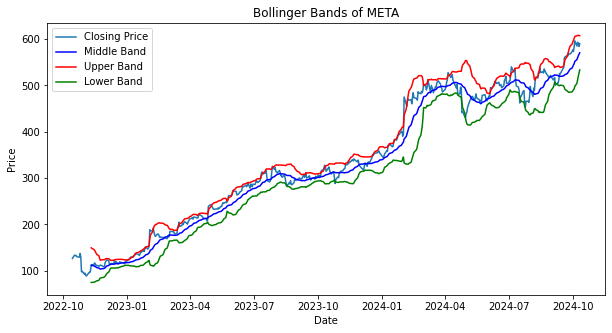

[*********************100%***********************]  1 of 1 completed


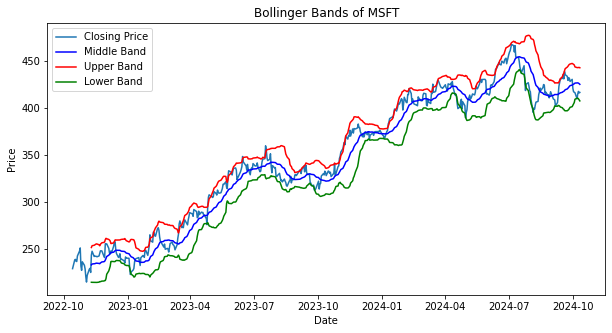

[*********************100%***********************]  1 of 1 completed


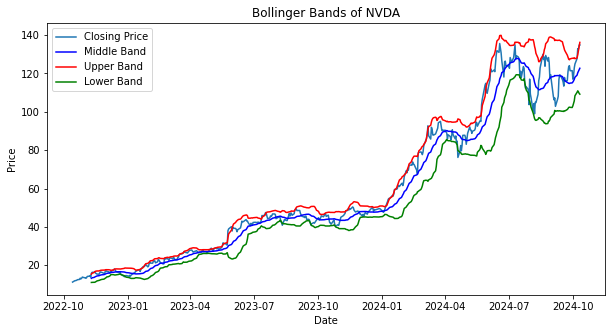

[*********************100%***********************]  1 of 1 completed


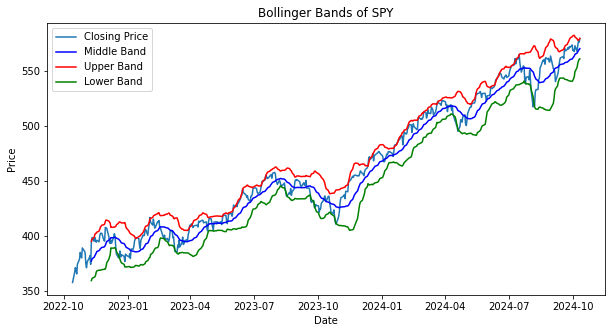

[*********************100%***********************]  1 of 1 completed


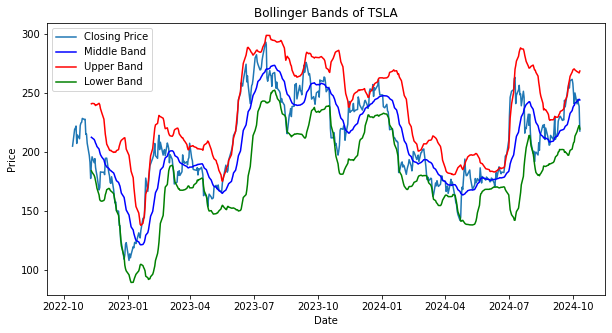

In [29]:
# Download historical data for each ticker and plot its Bollinger Bands
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_bollinger_bands(data_ticker, ticker)

### Price-to-Earnings Ratio (P/E)

**What is P/E Ratio:** The Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings. It is used to gauge whether a stock is overvalued or undervalued.

**How to Interpret:** A high P/E ratio may indicate that a stock is overvalued or that investors are expecting high growth rates in the future. A low P/E ratio may indicate that the stock is undervalued.

[*********************100%***********************]  1 of 1 completed


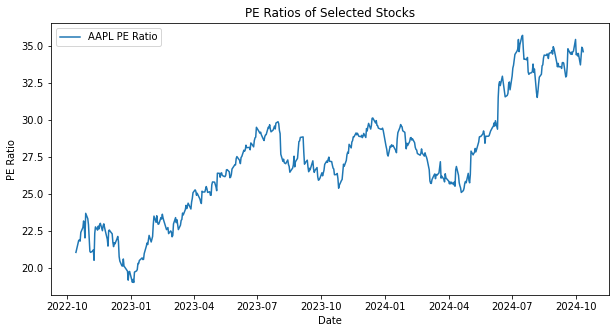

[*********************100%***********************]  1 of 1 completed


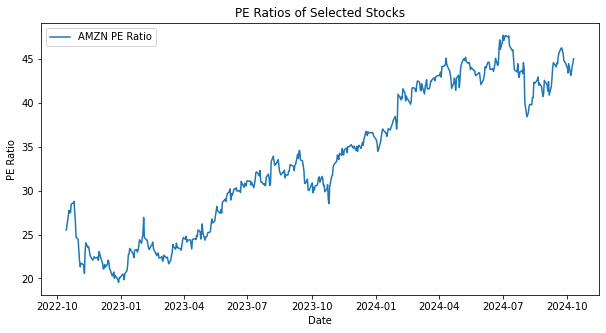

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


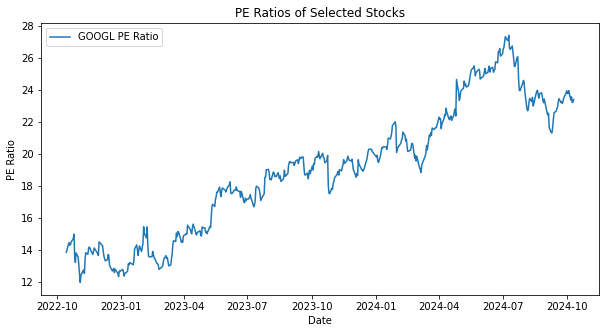

[*********************100%***********************]  1 of 1 completed


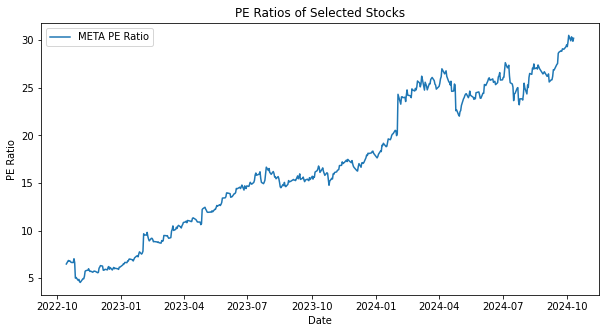

[*********************100%***********************]  1 of 1 completed


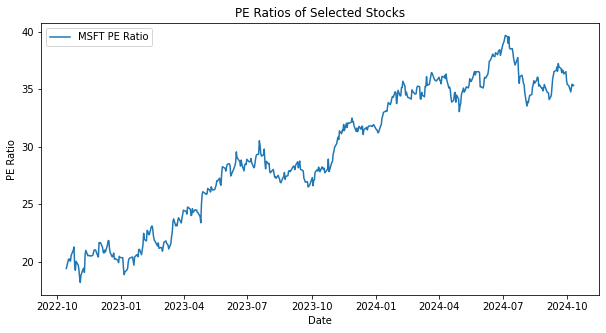

[*********************100%***********************]  1 of 1 completed


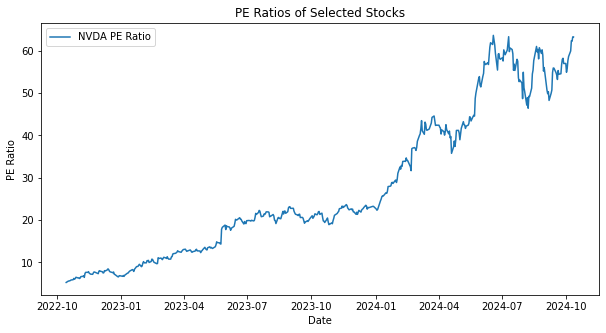

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


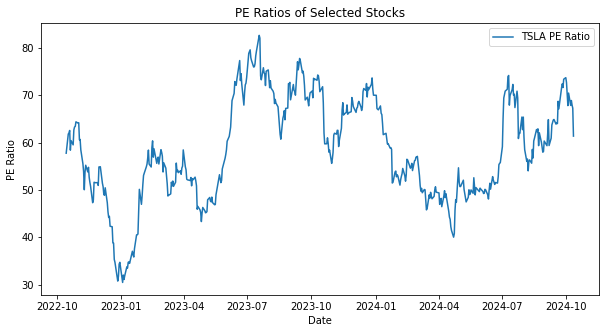

In [30]:
# Download historical data for each ticker and plot its P/E ratios
for ticker in tickers:
    stock = yf.Ticker(ticker)
    eps = stock.info.get('trailingEps') # Retrieve the trailing EPS value from the stock's info
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_pe_ratios(data_ticker, ticker, eps)

### Beta

**What is Beta:** Beta measures a stock's volatility relative to the overall market. A beta greater than 1 indicates higher volatility than the market, while a beta less than 1 indicates lower volatility.

**How to Interpret:** High beta values (>1) indicate that the stock is more volatile than the market, meaning it may offer higher returns but also higher risks. Low beta values (<1) indicate less volatility and potentially more stable returns.

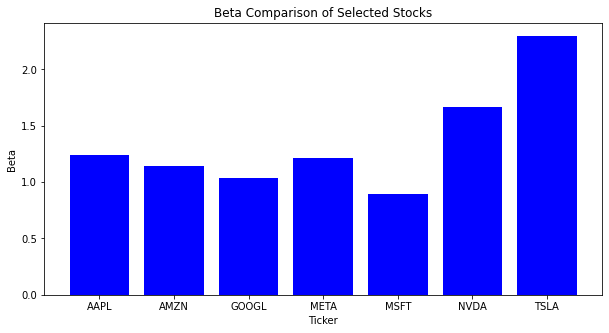

In [31]:
# Plot beta comparison for a list of tickers over a specified date range
plot_beta_comparison(tickers, start_date,end_date)

### Moving Average Convergence Divergence (MACD)

**What is MACD:** The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price.

**How to Interpret:** The MACD line crossing above the signal line indicates a bullish signal, suggesting that it may be time to buy. Conversely, the MACD line crossing below the signal line indicates a bearish signal, suggesting that it may be time to sell.

[*********************100%***********************]  1 of 1 completed


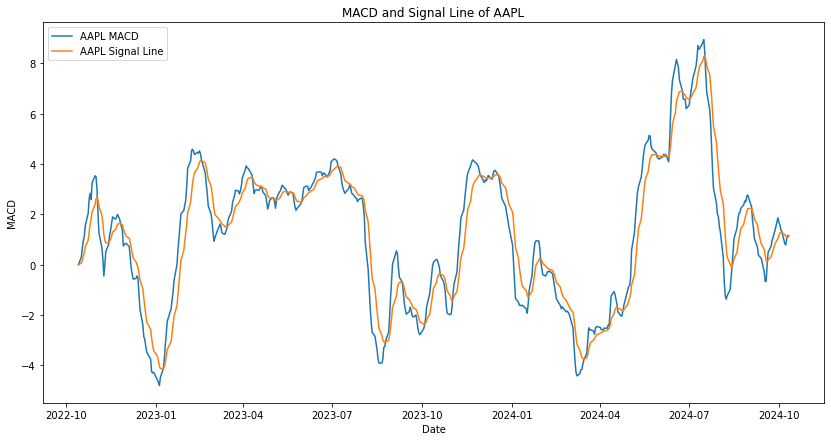

[*********************100%***********************]  1 of 1 completed


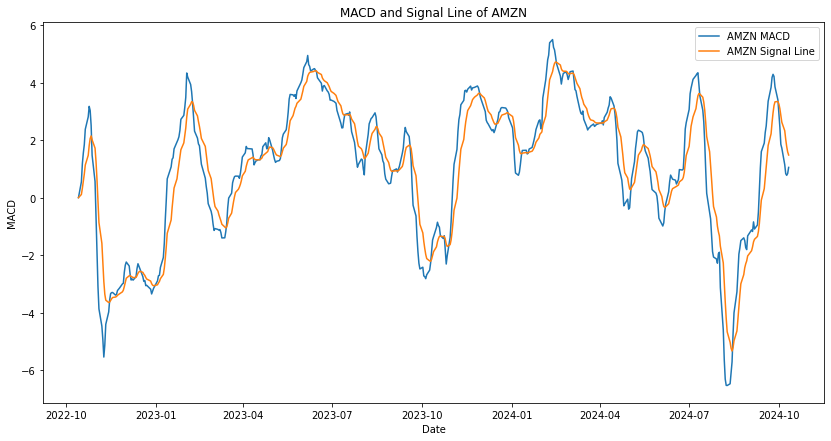

[*********************100%***********************]  1 of 1 completed


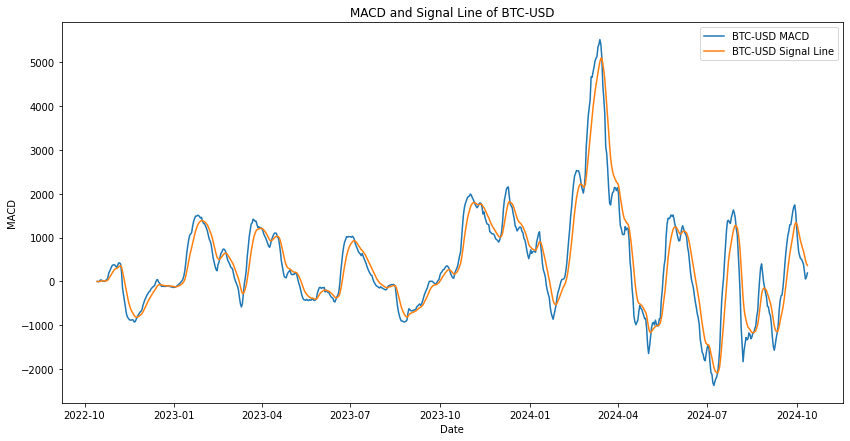

[*********************100%***********************]  1 of 1 completed


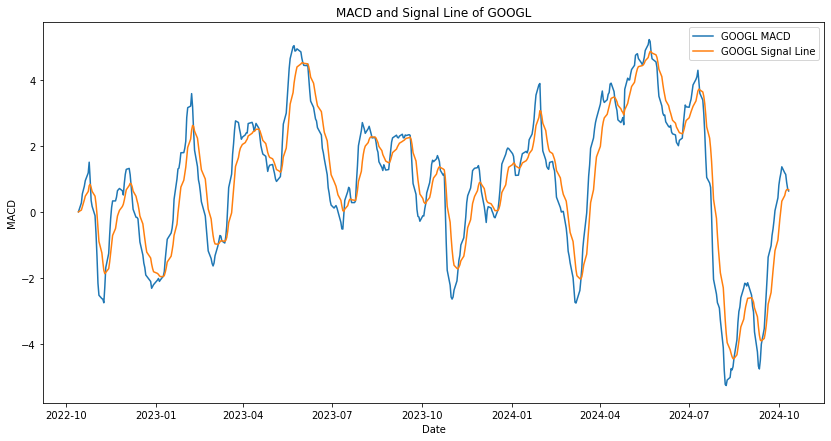

[*********************100%***********************]  1 of 1 completed


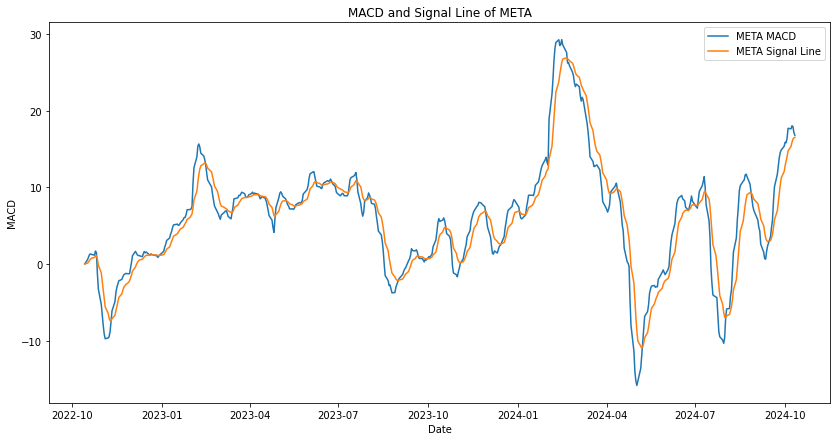

[*********************100%***********************]  1 of 1 completed


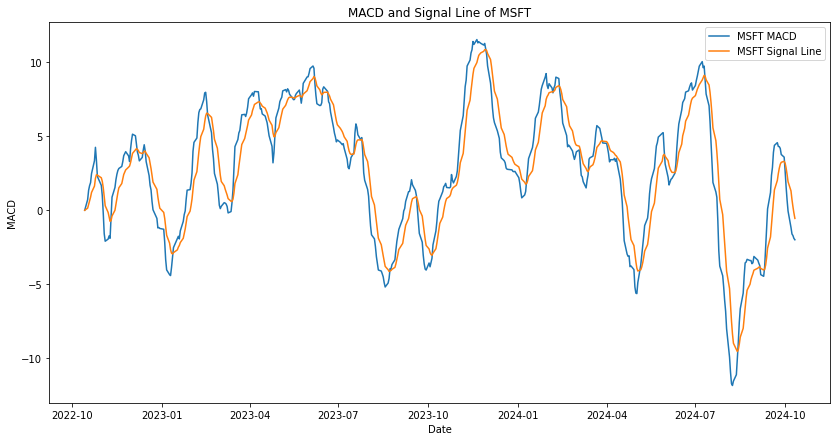

[*********************100%***********************]  1 of 1 completed


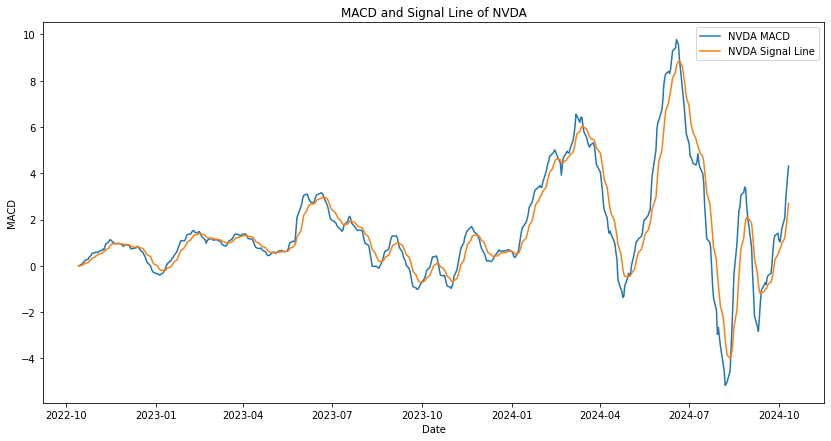

[*********************100%***********************]  1 of 1 completed


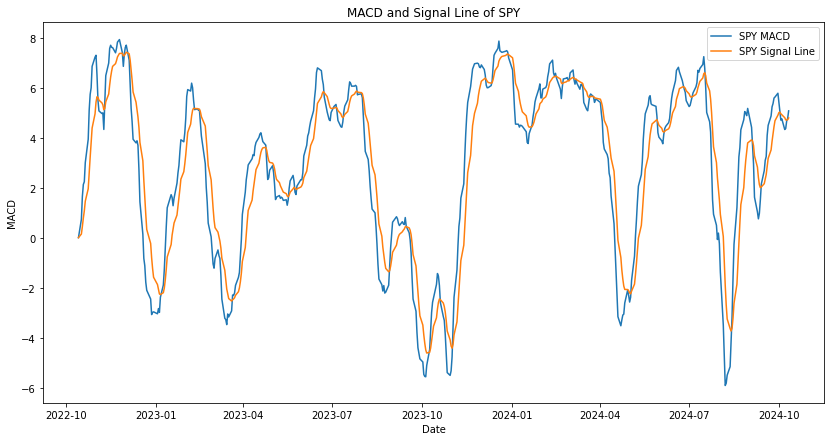

[*********************100%***********************]  1 of 1 completed


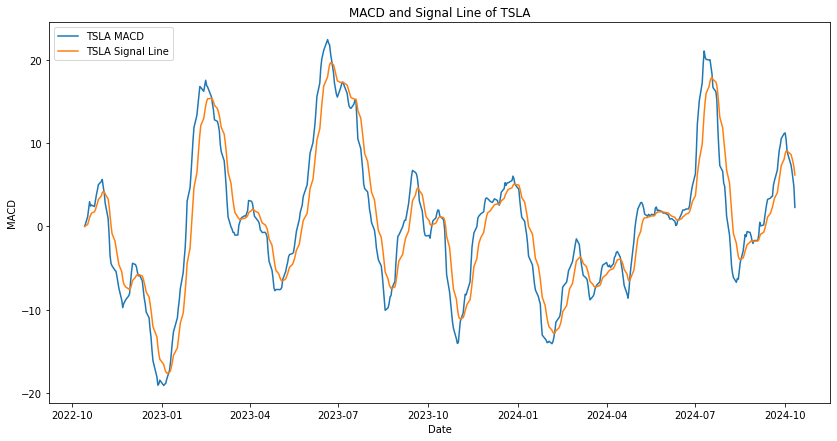

In [32]:
# Download historical data for each ticker and plot its MACD
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_macd(data_ticker, ticker)

### KPIs

In [33]:
# Calculate KPIs for the defined tickers and date range
kpi_data = calculate_kpis(tickers, start_date, end_date)

# Create a prompt to generate an executive summary with recommendations based on KPI data
prompt = f""" Read this data {kpi_data} and provide an executive summary with recommendations"""

# Get the response from the LLM based on the provided prompt
get_llm_response(llm = llm, prompt = prompt)

### Executive Summary

The data provided includes technical indicators and financial metrics for several major stocks and indices, including AAPL, AMZN, BTC-USD, GOOGL, META, MSFT, NVDA, SPY, and TSLA. The indicators include RSI, Bollinger Bands, P/E Ratio, Beta, and MACD, which are commonly used to assess market trends and stock performance.

#### Key Observations:

1. **Relative Strength Index (RSI):**
   - **AAPL**: RSI is around 51-56, indicating a neutral position.
   - **AMZN**: RSI is around 39-44, suggesting a potential oversold condition.
   - **BTC-USD**: RSI is around 27-40, indicating a potential oversold condition.
   - **GOOGL**: RSI is around 46-61, indicating a neutral position.
   - **META**: RSI is around 65-80, suggesting an overbought condition.
   - **MSFT**: RSI is around 25-35, indicating a potential oversold condition.
   - **NVDA**: RSI is around 67-78, suggesting an overbought condition.
   - **SPY**: RSI is around 58-66, indicating a neutral to slightly overbought position.
   - **TSLA**: RSI is around 31-59, indicating a neutral to slightly oversold position.

2. **Bollinger Bands:**
   - Most stocks are trading near their middle bands, indicating a lack of strong directional movement. However, some like NVDA and META are closer to their upper bands, suggesting potential overbought conditions.

3. **P/E Ratio:**
   - **AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA**: P/E ratios vary significantly, with NVDA and TSLA having higher ratios, indicating higher growth expectations or potential overvaluation.
   - **BTC-USD and SPY**: P/E ratios are not applicable.

4. **Beta:**
   - **TSLA** has the highest beta (2.297), indicating higher volatility compared to the market.
   - **MSFT** has the lowest beta (0.896), suggesting lower volatility.

5. **MACD:**
   - **AAPL, AMZN, GOOGL, META, MSFT, NVDA, SPY, TSLA**: MACD values suggest varying momentum, with some stocks like NVDA and META showing strong upward momentum, while others like MSFT and TSLA show declining momentum.

### Recommendations:

1. **AAPL**: Maintain a neutral stance. The RSI and Bollinger Bands suggest no strong directional bias. Monitor for any breakout or breakdown.

2. **AMZN**: Consider a potential buying opportunity if the RSI continues to indicate oversold conditions and if other indicators align.

3. **BTC-USD**: Exercise caution. The low RSI suggests oversold conditions, but the high volatility and lack of P/E ratio make it speculative.

4. **GOOGL**: Maintain a neutral stance. The indicators suggest a balanced position without strong directional bias.

5. **META**: Consider taking profits or reducing exposure. The high RSI and proximity to the upper Bollinger Band suggest overbought conditions.

6. **MSFT**: Monitor for a potential buying opportunity. The low RSI indicates oversold conditions, but confirm with other indicators.

7. **NVDA**: Exercise caution. The high RSI and P/E ratio suggest overbought conditions and potential overvaluation.

8. **SPY**: Maintain a neutral stance. The indicators suggest a balanced position without strong directional bias.

9. **TSLA**: Monitor closely. The high beta indicates volatility, and the RSI suggests a potential oversold condition, but confirm with other indicators.

### Conclusion:

The current market conditions suggest a mixed outlook across different stocks and indices. Investors should consider individual stock conditions, market trends, and risk tolerance when making investment decisions. Regular monitoring and a diversified portfolio approach are recommended to manage risk effectively.

### MPT

In [34]:
# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio performance metrics.

    Parameters:
    weights (array): Asset weights in the portfolio.
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.

    Returns:
    float: Portfolio returns.
    float: Portfolio standard deviation.
    """
    # Calculate the expected portfolio return
    returns = np.sum(mean_returns * weights)

    # Calculate the portfolio standard deviation (volatility)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# Function to calculate the negative Sharpe ratio
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Calculate the negative Sharpe ratio for a given portfolio.

    Parameters:
    weights (array): Asset weights in the portfolio.
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.
    risk_free_rate (float): Risk-free rate.

    Returns:
    float: Negative Sharpe ratio.
    """
    # Calculate the negative Sharpe ratio of the portfolio
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    # Return the negative Sharpe ratio (to minimize in optimization problems)
    return -(p_returns - risk_free_rate) / p_std

# Function to find the portfolio with the maximum Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Find the portfolio with the maximum Sharpe ratio.

    Parameters:
    mean_returns (Series): Mean returns for each asset.
    cov_matrix (DataFrame): Covariance matrix of asset returns.
    risk_free_rate (float): Risk-free rate.

    Returns:
    OptimizeResult: The optimization result containing the portfolio weights.
    """
    # Number of assets in the portfolio
    num_assets = len(mean_returns)

    # Define the arguments for the optimization function
    args = (mean_returns, cov_matrix, risk_free_rate)

    # Set up constraints (weights must sum to 1)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Define bounds for each asset weight (between 0 and 1)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Perform optimization to maximize the Sharpe ratio (minimize the negative Sharpe ratio)
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


# Fetch the adjusted close prices for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.04

# Optimize the portfolio for maximum Sharpe ratio
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x

# Store the optimal weights in a dictionary and print the result
weights_dict = {tickers[i]: round(optimal_weights[i], 2) for i in range(len(tickers))}
print(weights_dict)


[*********************100%***********************]  9 of 9 completed


{'AAPL': 0.0, 'AMZN': 0.0, 'BTC-USD': 0.0, 'GOOGL': 0.0, 'META': 0.0, 'MSFT': 0.0, 'NVDA': 1.0, 'SPY': 0.0, 'TSLA': 0.0}


Modern Portfolio Theory (MPT) aims to optimize the portfolio's return for a given level of risk. The Sharpe ratio is used to measure the performance of the portfolio compared to a risk-free asset, after adjusting for its risk. The portfolio with the highest Sharpe ratio is considered optimal.